# Moélisation de courbes de taux

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.interpolate import CubicSpline

In [2]:
# Import data
df = pd.read_excel("Data.xlsx")
df.columns = ["Market", "MAT", "MKT"]

In [3]:
df.head()
#df["MKT"] = 100 * df["MKT"]

,Market,MAT,MKT
0,MM,0.25,0.030698
1,MM,0.50,0.026191
2,MM,0.75,0.023958
3,MM,1.00,0.022979
4,FUT,1.25,0.978691


In [4]:
def bootstrap_yield_curve(df):
    """
    Bootstrap a yield curve from market data using cubic spline interpolation.

    Parameters:
        df (pd.DataFrame): Market data with columns ["Market", "MAT", "MKT"].

    Returns:
        pd.DataFrame: Yield curve with zero-coupon rates.
    """
    # Convert DataFrame into dictionary for faster lookup
    data = {market: df[df["Market"] == market].reset_index(drop=True) for market in ["MM", "FUT", "SWAP"]}

    # Step 1: Interpolate Swap Rates
    swap_data = data["SWAP"]
    spline = CubicSpline(swap_data["MAT"], swap_data["MKT"])
    maturities_annual = np.arange(3, 31, 1)
    interpolated_rates = spline(maturities_annual)

    # Combine interpolated data
    SWAP_interpolated = pd.DataFrame({"Market": "SWAP", "MAT": maturities_annual, "MKT": interpolated_rates})
    df_new = pd.concat([df[df["Market"] != "SWAP"], SWAP_interpolated])

    # Update data dictionary
    data["MM"] = df_new[df_new["Market"] == "MM"].reset_index(drop=True)
    data["FUT"] = df_new[df_new["Market"] == "FUT"].reset_index(drop=True)
    data["SWAP"] = df_new[df_new["Market"] == "SWAP"].reset_index(drop=True)

    # Step 2: Compute Zero-Coupon Rates for MM
    data["MM"]["B(0,MAT)"] = 1 / (1 + data["MM"]["MAT"] * data["MM"]["MKT"])
    data["MM"]["tx ZC"] = -np.log(data["MM"]["B(0,MAT)"]) / data["MM"]["MAT"]

    # Step 3: Compute Zero-Coupon Rates for Futures
    data["FUT"]["B(0,MAT)"] = data["MM"]["B(0,MAT)"].iloc[-1]
    B_tau_i = data["FUT"].iloc[0]["B(0,MAT)"]
    tau_i = 1

    for i, row in data["FUT"].iterrows():
        T_i, f_i = row["MAT"], row["MKT"]
        B_tau_i /= (1 + (T_i - tau_i) * (1 - f_i))
        data["FUT"].at[i, "B(0,MAT)"] = B_tau_i
        tau_i = T_i

    data["FUT"]["tx ZC"] = -np.log(data["FUT"]["B(0,MAT)"]) / data["FUT"]["MAT"]

    # Step 4: Compute Zero-Coupon Rates for Swaps
    B_T_1 = data["MM"].loc[data["MM"]["MAT"] == 1, "B(0,MAT)"].values[0]
    B_T_2 = data["FUT"].loc[data["FUT"]["MAT"] == 2, "B(0,MAT)"].values[0]
    A = B_T_1 + B_T_2

    data["SWAP"]["B(0,MAT)"] = (1 - data["SWAP"]["MKT"].iloc[0] * A) / (1 + data["SWAP"]["MKT"].iloc[0])

    for i in range(1, len(data["SWAP"])):
        A += data["SWAP"].iloc[i - 1]["B(0,MAT)"]
        data["SWAP"].at[i, "B(0,MAT)"] = (1 - data["SWAP"].iloc[i]["MKT"] * A) / (1 + data["SWAP"].iloc[i]["MKT"])

    data["SWAP"]["tx ZC"] = -np.log(data["SWAP"]["B(0,MAT)"]) / data["SWAP"]["MAT"]

    # Combine results
    yield_curve = pd.concat(data.values())

    # Plot the yield curve
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=yield_curve["MAT"], y=yield_curve["tx ZC"], marker="o", linestyle="-", label="Zero-Coupon Rate Curve")
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Zero-Coupon Rate")
    plt.title("Bootstrapped Zero-Coupon Rate Curve )")
    plt.grid(True)
    plt.legend()
    plt.show()

    return yield_curve


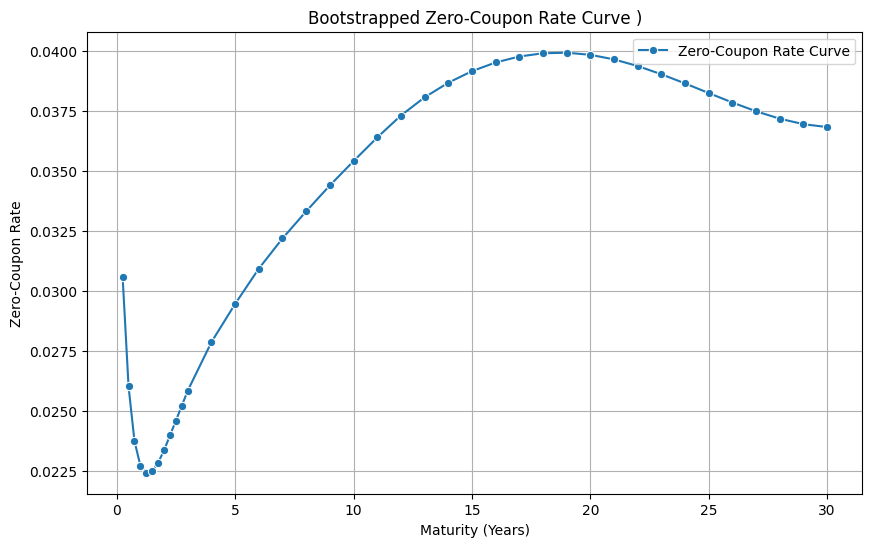

In [5]:
yield_zc = bootstrap_yield_curve(df)

In [6]:
#1.3
# Courbe des taux forward de tenor 3 mois

from scipy.interpolate import interp1d, CubicSpline

def compute_forward_rates(yield_curve):
    """
    Calcule les taux forward 3M à partir des taux zéro-coupon.
    
    Parameters:
    yield_curve (pd.DataFrame): Contient 'MAT' (maturité) et 'B(0,MAT)' (Prix ZC).
    
    Returns:
    pd.DataFrame: Contenant 'MAT' et 'Forward 3M'.
    """
    
    # Convertir les maturités en mois
    yield_curve["MAT_months"] = yield_curve["MAT"] * 12
    
    # Sélection des maturités tous les 3 mois
    maturities = np.arange(3, max(yield_curve["MAT_months"]), 3) / 12  # en années

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Interpolation log-linéaire sur B(0,T) pour estimer B(0,T) pour ces maturités
    log_interp_bond_prices = interp1d(yield_curve["MAT"], np.log(yield_curve["B(0,MAT)"]), kind="linear", fill_value="extrapolate")
    
    # Calcul des prix interpolés
    B_t = np.exp(log_interp_bond_prices(maturities))
    B_t_3M = np.exp(log_interp_bond_prices(maturities + 0.25))  # 3 mois plus tard

    # Calcul du taux forward 3M
    forward_rates_log = ((B_t / B_t_3M) - 1)/0.25
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Interpolation linéaire sur les tx ZC pour estimer B(0,T) pour ces maturités
    lin_interp_bond_prices = interp1d(yield_curve["MAT"], yield_curve["tx ZC"], kind="linear", fill_value="extrapolate")
    
    # Calcul des prix interpolés
    B_t = np.exp(-lin_interp_bond_prices(maturities)*maturities)
    B_t_3M = np.exp(-lin_interp_bond_prices(maturities + 0.25)*(maturities + 0.25))  # 3 mois plus tard

    # Calcul du taux forward 3M
    forward_rates_lin = ((B_t / B_t_3M) - 1)/0.25
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Interpolation cubic des tx ZC pour estimer B(0,T) pour ces maturités
    spline_interp_bond_prices = CubicSpline(yield_curve["MAT"], yield_curve["tx ZC"])
    
    # Calcul des prix interpolés
    B_t = np.exp(-spline_interp_bond_prices(maturities)*maturities)
    B_t_3M = np.exp(-spline_interp_bond_prices(maturities + 0.25)*(maturities + 0.25))  # 3 mois plus tard

    # Calcul du taux forward 3M
    forward_rates_spline = ((B_t / B_t_3M) - 1)/0.25
    
    

    return {"MAT": maturities,
                        "Interpolation Linéaire": forward_rates_lin,
                        "Interpolation log-linéaire": forward_rates_log,
                        "Interpolation Spline": forward_rates_spline}

def plot_forward_curve(forward_rates, columns = ["Interpolation Spline", "Interpolation Linéaire"]):
    """
    Trace la courbe des taux forwards en utilisant l'interpolation linéaire et spline.
    
    Parameters:
    forward_rates (pd.DataFrame): Contenant 'MAT' et 'Forward 3M'.
    """
    # Tracé des courbes
    plt.figure(figsize=(10, 6))
    for col in columns:
        plt.plot(forward_rates["MAT"], forward_rates[col],  label=col)
    

    plt.xlabel("Maturité (années)")
    plt.ylabel("Taux Forward 3M")
    plt.title("Courbe des Taux Forwards 3M")
    plt.legend()
    plt.grid()
    plt.show()


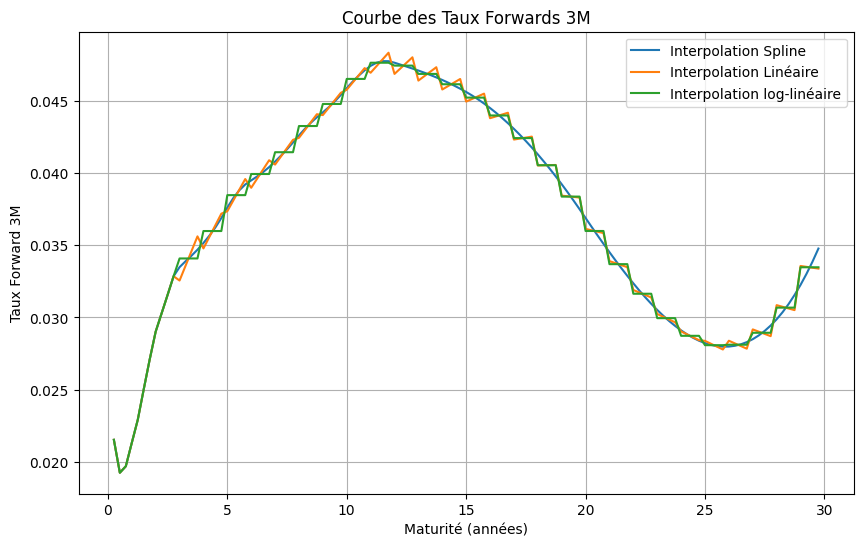

In [7]:
# Calcul de la courbe des taux forwards
forward_rates = pd.DataFrame(compute_forward_rates(yield_zc))

# Tracé des courbes interpolées
plot_forward_curve(forward_rates, columns = ["Interpolation Spline", "Interpolation Linéaire","Interpolation log-linéaire"])


In [8]:
# 1bp = 0.01% donc 10bps = 0.10%=0.0001
df_bumped = yield_zc.copy()
df_bumped.loc[df_bumped["MAT"]==5,"MKT"] = df_bumped.loc[df_bumped["MAT"]==5,"MKT"] + 0.001

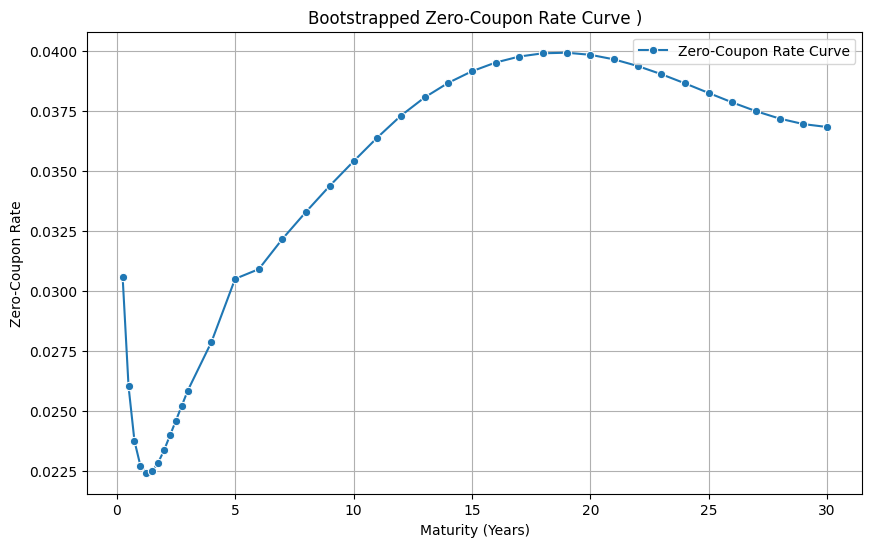

In [9]:
yield_bumped = bootstrap_yield_curve(df_bumped)


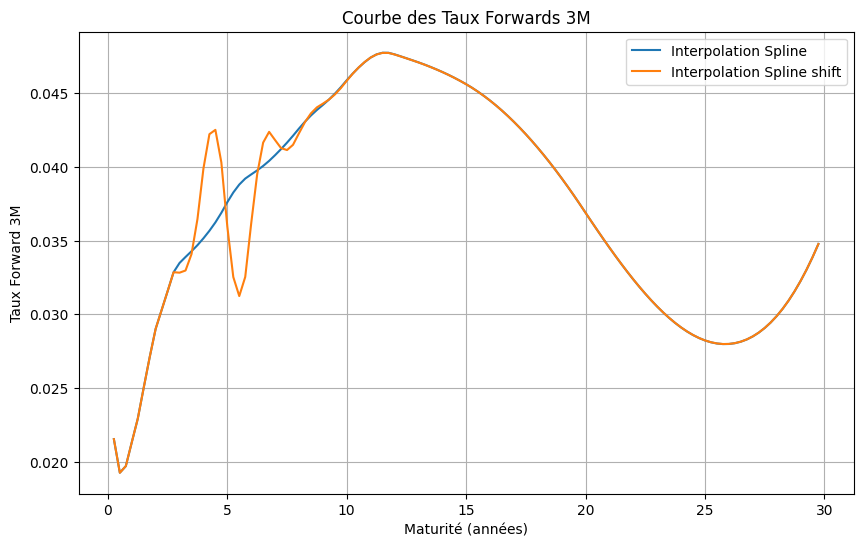

In [10]:
# Calcul de la courbe des taux forwards
forward_rates_bumped = pd.DataFrame(compute_forward_rates(yield_bumped))
forward_rates_bumped.rename(columns={"Interpolation Linéaire": "Interpolation Linéaire shift",
                                    "Interpolation log-linéaire": "Interpolation log-linéaire shift",
                                    "Interpolation Spline": "Interpolation Spline shift"}, inplace=True)

forward_rates_bumped = forward_rates_bumped.merge(forward_rates, on="MAT", how="inner")
#col = list(forward_rates_bumped.columns)
#col.remove("MAT")
# Tracé des courbes interpolées
plot_forward_curve(forward_rates_bumped, columns=["Interpolation Spline", "Interpolation Spline shift"])


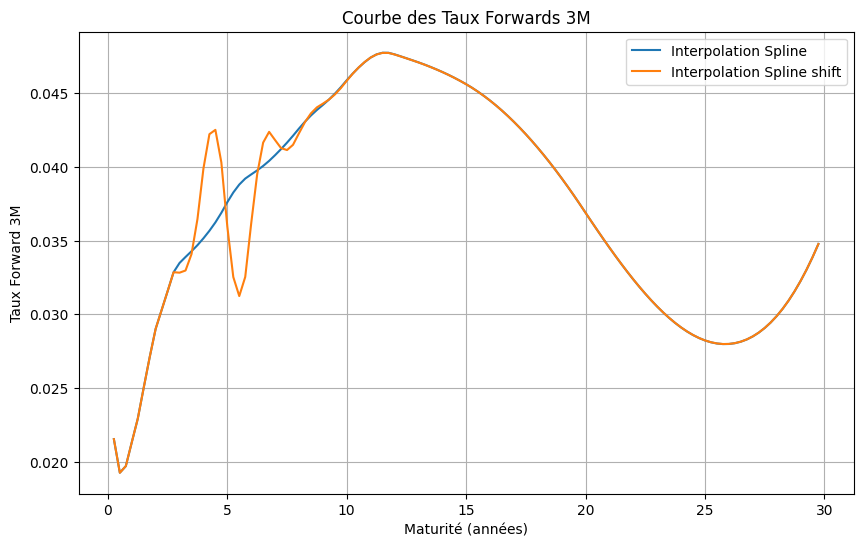

In [11]:
plot_forward_curve(forward_rates_bumped, columns=["Interpolation Spline", "Interpolation Spline shift"])

In [16]:
yield_zc.head()

,Market,MAT,MKT,"B(0,MAT)",tx ZC,MAT_months
0,MM,0.25,0.030698,0.992384,0.030581,3.0
1,MM,0.50,0.026191,0.987074,0.026021,6.0
2,MM,0.75,0.023958,0.982349,0.023745,9.0
3,MM,1.00,0.022979,0.977537,0.022719,12.0
0,FUT,1.25,0.978691,0.972357,0.022426,15.0


In [ ]:
from scipy.stats import norm

def sigma(T_i_1, T_i, lambd, vol):
    beta = (1-np.exp(-lambd*(T_i - T_i_1)))/lambd
    sigma = np.sqrt((2*lambd*T_i_1)/(1-np.exp(-2*lambd*T_i_1))) * vol / beta
    return sigma

def P_HW(t,Z, K, T_i_1, T_i, B, vol):
    delta = T_i - T_i_1
    d1 = (np.log(Z/K) + 0.5 * (vol**2)*(T_i_1 - t))/(vol * np.sqrt(T_i_1 - t))
    d2 = d1 - vol*np.sqrt(T_i_1 - t)
    caplet = delta * B[1] * (Z * norm.cdf(d1) - K * norm.cdf(d2))
    return caplet

In [71]:
t = 0
T_i_1 = 5
T_i = 5 + 1
lambd = 0.05
P_MKT = 0.7137 / 100
B = np.array([yield_zc[yield_zc.MAT==T_i_1]["B(0,MAT)"],
yield_zc[yield_zc.MAT==T_i]["B(0,MAT)"] ])
Z = B[0] / B[1]
K = (Z-1)/(T_i-T_i_1)

In [116]:
# Recherche de la vol implicite par dichotomie
sig_inf = 1e-8
sig_sup = 1e1
epsi = 1e-8
sig_moy = (sig_inf + sig_sup)/2
error = sig_sup - sig_inf

while error>epsi:
    p_hw = P_HW(t,Z, K, T_i_1, T_i, B, vol=sig_moy)
    if p_hw > P_MKT:
        sig_sup = sig_moy
    elif p_hw < P_MKT:
        sig_inf = sig_moy
    sig_moy = (sig_inf + sig_sup)/2
    error = np.abs(sig_sup - sig_inf)

vol_imp = sig_moy
    

In [117]:
# Vol implicte optimale
vol_imp

0.009270474060870853

In [118]:
# Vol instantanée
vol_inst = sigma(T_i_1, T_i, lambd, vol=sig_moy)
vol_inst

0.01071380211500768

In [120]:
P_HW(t,Z, K, T_i_1, T_i, B, vol_imp)

array([0.007137])

In [122]:
strikes = K + np.array([-100, -50, -25, 0, 25, 50, 100])/10_000

caplets = np.array([P_HW(t,K, strike, T_i_1, T_i, B, vol_imp) for strike in strikes])

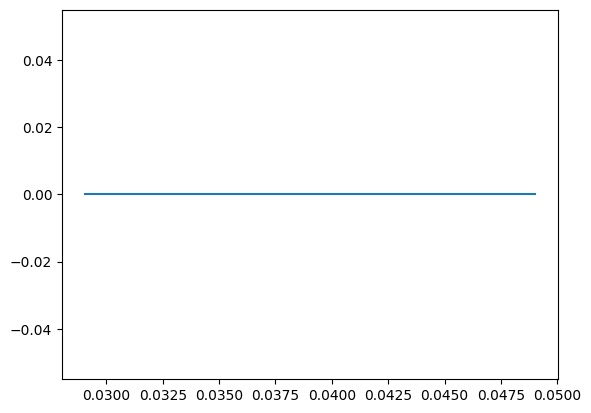

In [123]:
plt.plot(strikes, caplets)

In [100]:
from scipy.optimize import fsolve

# Function to solve for vol (inverting P_HW)
def find_vol(caplet, t, Z, K, T_i_1, T_i, B):
    def objective(vol):
        return P_HW(t, Z, K, T_i_1, T_i, B, vol) - caplet  # Solve P_HW(vol) = target_caplet
    
    vol_guess = 0.01  # Initial guess for volatility
    vol_solution = fsolve(objective, vol_guess)[0]
    return vol_solution

In [113]:
#vols = np.array([find_vol(caplet, t, Z, K, T_i_1, T_i, B) for caplet in caplets])
vols_inst = np.array([sigma(T_i_1, T_i, lambd, vol=vol) for vol in vols])


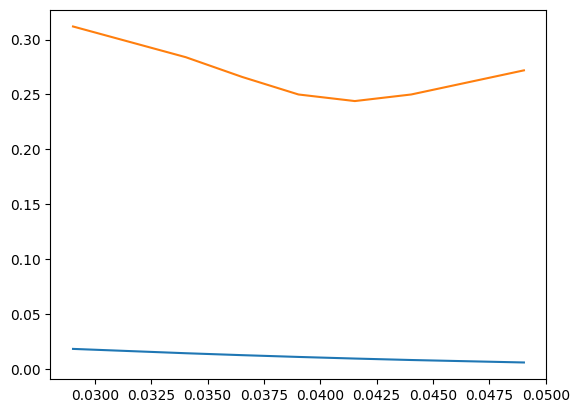

In [115]:
vol_mkt = np.array([31.2, 28.4, 26.6, 25.0, 24.4, 25.0, 27.2]) / 100
plt.plot(strikes, vols_inst)
plt.plot(strikes, vol_mkt)

In [ ]:
#3.7. 